# American Sign Language | Sign Predictor

- Some points about what it is, why are we doing it, how we're gonna do it

Importing Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import random
from random import sample

import os
import glob
import cv2
import zipfile
import time

Defining Changeable Variables

In [2]:
ROOT_DIR = "dataset/asl_alphabet_train/asl_alphabet_train/"
PIXELSIZE = 32
PIXELTIMES = PIXELSIZE * PIXELSIZE

MAX_IMAGES_PER_CLASS = 500  # Set the maximum number of images per class
TRAIN_SIZE = 14000 # 29 * 220

# Retrieving the Data
Data Link: https://www.kaggle.com/datasets/grassknoted/asl-alphabet

In [3]:
if os.path.exists("archive.zip"):
    print("Data zip exists.")
else:
    print("Download dataset from https://www.kaggle.com/datasets/grassknoted/asl-alphabet and place in directory!")
    

Data zip exists.


Unzipping the dataset archive.zip and extracting to folder 'dataset'.

In [4]:
# Create the output directory if it doesn't exist
if not os.path.exists("dataset"):
    os.makedirs("dataset")

    # Open the ZIP file for reading
    with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
        # Extract all the contents of the ZIP file to the output directory
        zip_ref.extractall("dataset")

    print(f'Unzipped archive.zip dataset directory.')

else:
    print("Dataset already exists")

Dataset already exists


# Data Importation and Pre-Processing

In [5]:
image_data = {}

for class_folder in os.listdir(ROOT_DIR):
    class_path = os.path.join(ROOT_DIR, class_folder)
    if os.path.isdir(class_path):
        class_images = []
        for image_file in glob.glob(os.path.join(class_path, "*.jpg")):  # Change the file extension as needed
            class_images.append(image_file)
        image_data[class_folder] = class_images

Extracting the classes and images into 'classes' and 'images' list

In [6]:
class_number_dict = {}

images = []
classes = []
classNumber = 0

for class_name, image_paths in image_data.items():
    class_count = 0  # Initialize a counter for the current class
    for image_path in image_paths:
        if isinstance(image_path, str) and os.path.exists(image_path):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (PIXELSIZE, PIXELSIZE), interpolation=cv2.INTER_LINEAR)

            if image is not None:  # Check if the image was successfully loaded
                images.append(image)
                classes.append(classNumber)
                class_count += 1

            if class_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop loading images for the current class

    class_number_dict[class_name] = classNumber
    classNumber += 1

Combining the lists so they can be shuffled and seperating them

In [7]:
# Combine the two lists into pairs
combined_lists = list(zip(classes, images))

# Shuffle the pairs
random.shuffle(combined_lists)

# Unzip the shuffled pairs back into separate lists
classes, images = zip(*combined_lists)

Converting to Numpy array

In [8]:
classes = np.array(classes)
images = np.array(images)

Reshaping the array so it will fit into the Neural Network

In [9]:
images = images.reshape(-1, PIXELTIMES)

Splitting the data into a training and testing set

In [10]:
X_train = images[0:TRAIN_SIZE]
y_train = classes[0:TRAIN_SIZE]

X_test = images[TRAIN_SIZE:classes.size]
y_test = classes[TRAIN_SIZE:images.size]

Transposing the data and normalising it

In [11]:
X_train = X_train.T
y_train = y_train.T

X_test = X_test.T
y_test = y_test.T

X_train = X_train / 255.
X_test = X_test / 255.

Printing the final shape of the array

In [12]:
print(X_train.shape)
print(y_train.shape)

(1024, 14000)
(14000,)


# Exploratory Data Analysis

Printing all the class names and count of images per class

In [13]:
for class_name, images in image_data.items():
    print(f"Class: {class_name}\tCount: {len(images)}")

Class: A	Count: 3000
Class: B	Count: 3000
Class: C	Count: 3000
Class: D	Count: 3000
Class: del	Count: 3000
Class: E	Count: 3000
Class: F	Count: 3000
Class: G	Count: 3000
Class: H	Count: 3000
Class: I	Count: 3000
Class: J	Count: 3000
Class: K	Count: 3000
Class: L	Count: 3000
Class: M	Count: 3000
Class: N	Count: 3000
Class: nothing	Count: 3000
Class: O	Count: 3000
Class: P	Count: 3000
Class: Q	Count: 3000
Class: R	Count: 3000
Class: S	Count: 3000
Class: space	Count: 3000
Class: T	Count: 3000
Class: U	Count: 3000
Class: V	Count: 3000
Class: W	Count: 3000
Class: X	Count: 3000
Class: Y	Count: 3000
Class: Z	Count: 3000


Displaying images and their class

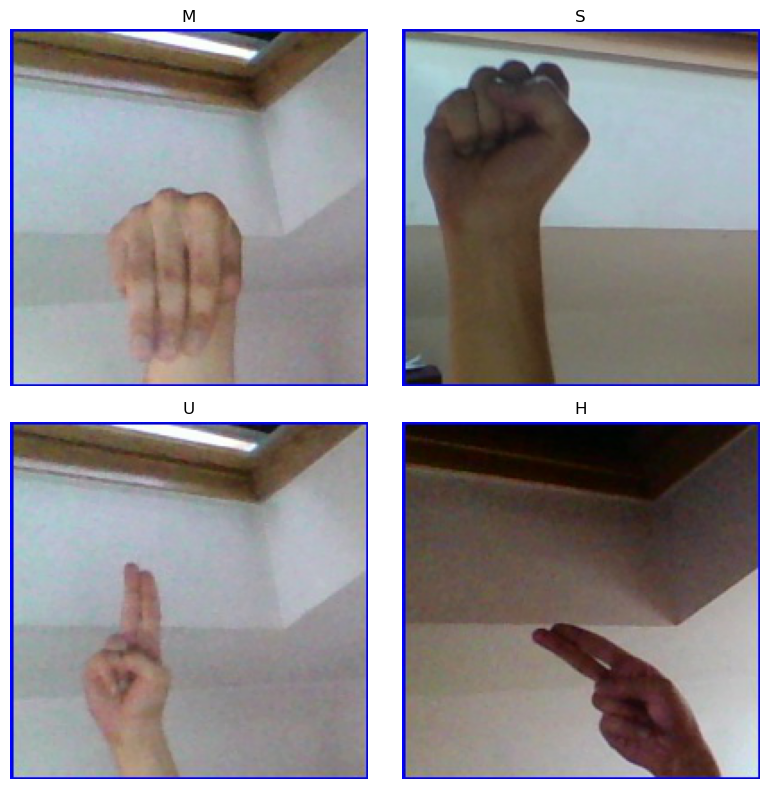

In [14]:
# Select 4 random classes
random_classes = random.sample(list(image_data.keys()), 4)

# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot one random image from each class
for i, class_name in enumerate(random_classes):
    row = i // 2
    col = i % 2
    random_image = random.choice(image_data[class_name])
    img = mpimg.imread(random_image)
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Neural Network Building

### Neural Network Activation Functions and Data Preparation Functions
1. **ReLU Activation Function (`ReLU` function)**:
   - The `ReLU` (Rectified Linear Unit) activation function is defined to take an input array `Z` and return an array where each element is the maximum of `Z` and 0.
   - Mathematically, `ReLU(Z) = max(0, Z)`.
   - ReLU is a popular activation function that introduces non-linearity to the neural network by allowing positive values to pass through unchanged and setting negative values to zero.
<br><br>
2. **Softmax Activation Function (`softmax` function)**:
   - The `softmax` activation function is defined to take an input array `Z` and compute the softmax values for each element.
   - It exponentiates each element of `Z`, divides it by the sum of exponentiated values across `Z`, and returns the resulting array.
   - The softmax function is often used in the output layer of a neural network for multi-class classification tasks, as it converts raw scores into class probabilities.
<br><br>
3. **Derivative of ReLU Activation Function (`ReLU_deriv` function)**:
   - The `ReLU_deriv` function computes the derivative of the ReLU activation function.
   - It takes an input array `Z` and returns an array of the same shape where each element is 1 if the corresponding element in `Z` is greater than 0, and 0 otherwise.
   - This derivative is used during backpropagation in training neural networks to compute gradients for weight updates.
<br><br>
4. **One-Hot Encoding Function (`one_hot` function)**:
   - The `one_hot` function is defined to convert class labels to one-hot encoded vectors.
   - It takes an array `Y` of class labels and transforms it into a one-hot matrix where each row corresponds to a sample, and each column represents a class.
   - The function first determines the size of the one-hot matrix based on the maximum class label in `Y`.
   - It initializes a matrix of zeros and sets the appropriate elements to 1 based on class labels, resulting in a one-hot encoded representation.
   - The final one-hot matrix is transposed to have one-hot vectors as columns, making it suitable for use in neural network training and classification tasks.

In [15]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((TRAIN_SIZE, PIXELSIZE))
    one_hot_Y[np.arange(TRAIN_SIZE), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

### Description of NeuralNet Class
The `NeuralNet` class is a Python implementation of a simple feedforward neural network, often used for supervised machine learning tasks like classification. It consists of methods for initializing the network, performing forward and backward propagation for training, making predictions, evaluating accuracy, and saving the model.
<br><br>
1. **Initialization (`__init__` method)**:
   - When an instance of the `NeuralNet` class is created, it initializes the neural network's parameters:
     - `W1`, `B1`, `W2`, and `B2` represent the weights and biases for two layers.
     - These parameters are randomly initialized with small values between -0.5 and 0.5.
<br><br>
2. **Forward Propagation (`forward_prop` method)**:
   - This method performs the forward pass through the network:
     - Calculates the weighted sum and applies the Rectified Linear Unit (ReLU) activation function for the first layer.
     - Calculates the weighted sum and applies the softmax activation function for the second layer.
   - The results of these calculations are stored in `self.Z1`, `self.A1`, `self.Z2`, and `self.A2`.
<br><br>
3. **Backward Propagation (`backward_prop` method)**:
   - This method performs backward propagation to compute gradients for updating the network's parameters:
     - Calculates gradients for the second layer (`self.dW2` and `self.db2`).
     - Calculates gradients for the first layer (`self.dW1` and `self.db1`) using the chain rule.
   - Gradients are computed with respect to the loss between predicted and actual values.
<br><br>
4. **Update Parameters (`update_params` method)**:
   - This method updates the model's parameters (weights and biases) using the computed gradients and a specified learning rate (`alpha`).
<br><br>
5. **Cross-Entropy Loss (`calculate_loss` method):**
- Calculates the cross-entropy loss for a classification problem. 
- It takes true labels `Y`, converts them to one-hot encoding.
- Computes the negative sum of the element-wise product of the one-hot labels and predicted class probabilities, and normalizes the result by dividing it by the training set size (`TRAIN_SIZE`). 
- This loss is commonly used in classification tasks to measure the dissimilarity between predicted and actual class distributions.

6. **Training (`train` method)**:
   - The `train` method trains the neural network for a specified number of iterations:
     - It repeatedly performs forward and backward propagation and parameter updates.
     - At regular intervals, it calculates and records the accuracy on the training data.
     - It also tracks and prints the time elapsed during training.
     - Returns a history of training accuracy and loss.
<br><br>
7. **Get Predictions (`get_predictions` method)**:
   - This method predicts class labels for a given dataset by performing forward propagation.
<br><br>
8. **Get Accuracy (`get_accuracy` method)**:
   - The `get_accuracy` method calculates the accuracy of the model's predictions on a given dataset.
<br><br>
9. **Save Model (`save_model` method)**:
   - This method allows the user to save the model's learned parameters to a binary file.
   - The weights, biases, and other relevant information are stored in a dictionary and saved to the specified file path.

In [16]:
class NeuralNet:
    def __init__(self):
        self.W1 = np.random.rand(PIXELSIZE, PIXELTIMES) - 0.5
        self.B1 = np.random.rand(PIXELSIZE, 1) - 0.5
        self.W2 = np.random.rand(PIXELSIZE, PIXELSIZE) - 0.5
        self.B2 = np.random.rand(PIXELSIZE, 1) - 0.5

    def forward_prop(self, X):
        self.Z1 = self.W1.dot(X) + self.B1
        self.A1 = ReLU(self.Z1)
        self.Z2 = self.W2.dot(self.A1) + self.B2
        self.A2 = softmax(self.Z2)

    def backward_prop(self, X, Y):
        one_hot_Y = one_hot(Y)
        dZ2 = self.A2 - one_hot_Y

        self.dW2 = 1 / TRAIN_SIZE * dZ2.dot(self.A1.T)
        self.db2 = 1 / TRAIN_SIZE * np.sum(dZ2)

        dZ1 = self.W2.T.dot(dZ2) * ReLU_deriv(self.Z1)

        self.dW1 = 1 / TRAIN_SIZE * dZ1.dot(X.T)
        self.db1 = 1 / TRAIN_SIZE * np.sum(dZ1)
        
    def update_params(self, alpha):
        self.W1 = self.W1 - alpha * self.dW1
        self.B1 = self.B1 - alpha * self.db1    
        self.W2 = self.W2 - alpha * self.dW2
        self.B2 = self.B2 - alpha * self.db2

    def calculate_loss(self, Y):
        one_hot_Y = one_hot(Y)
        loss = -np.sum(one_hot_Y * np.log(self.A2)) / TRAIN_SIZE
        return loss

    def train(self, X, Y, alpha, iterations, filepath):
        history = []
        start_time = time.time()  # Record the start time
        
        # Initialize the Best Model Values
        best_loss = float('inf')  
        best_accuracy = 0.0
        best_iteration = 0

        for i in range(iterations):
            self.forward_prop(X)
            self.backward_prop(X, Y)
            self.update_params(alpha)
            
            if i % 100 == 0:
                acc = np.sum(np.argmax(self.A2, 0) == Y) / Y.size
                loss = self.calculate_loss(Y)  # Calculate the loss
                history.append([i, acc, loss])
                
                elapsed_time = time.time() - start_time  # Calculate elapsed time in seconds
                elapsed_time_minutes = elapsed_time / 60  # Convert elapsed time to minutes

                print(f"Iteration: {i:>5}\tAccuracy: {acc * 100:.2f}% \tLoss: {loss:.4f}\tTime elapsed: {elapsed_time_minutes:.2f} minutes")

            if loss < best_loss:
                best_loss = loss
                best_accuracy = acc
                best_iteration = i

                self.save_model(filepath)
                print(f"Saving Best Model with Loss: {best_loss}")
                
        print(f"Best Model - Iteration: {best_iteration}\tAccuracy: {best_accuracy * 100:.2f}% \tLoss: {best_loss:.4f}")
        return history

    def get_predictions(self, testSet):
        Z1 = self.W1.dot(testSet) + self.B1
        A1 = ReLU(Z1)
        Z2 = self.W2.dot(A1) + self.B2
        A2 = softmax(Z2)
        return np.argmax(A2, 0)
    
    def get_accuracy(self, Xset, Yset):
        return np.sum(self.get_predictions(Xset) == Yset) / Yset.size
    
    def save_model(self, filepath):
        # Create a dictionary to store the weights and biases
        network = {
            'weights_1': self.W1,
            'biases_1': self.B1,
            'weights_2': self.W2,
            'biases_2': self.B2,
            'class_number_dict': class_number_dict
        }

        # Save the weights and biases to a binary file
        np.save(filepath, network)

# Training the Model

1. **Initialization of Neural Network**:
   - `nn = NeuralNet()` creates an instance of the `NeuralNet` class, initializing a neural network with random weights and biases. This network will be used for a machine learning task.
<br><br>
2. **Training the Neural Network**:
   - `history = nn.train(X_train, y_train, 0.10, 10000)` trains the neural network using the specified training data and hyperparameters.
     - `X_train` is the input training data, likely a matrix where each row represents a training example.
     - `y_train` contains the corresponding target labels for the training data.
     - `0.10` is the learning rate (alpha) used for updating the network's parameters during training.
     - `100000` is the number of training iterations, defining how many times the network will update its parameters while learning.
     - `webpage/neural_network_weights.npy` is the filepath for where to save the best model. This file will contain the weights and biases of the neural network, allowing it to be later loaded and used for making predictions on new data or for further training.
   - The training process involves forward and backward propagation, parameter updates, and accuracy monitoring. The training history, including accuracy at intervals, is stored in the `history` variable.

In [17]:
nn = NeuralNet()
history = nn.train(X_train, y_train, 0.10, 100000, "webpage/neural_network_weights.npy")

Iteration:     0	Accuracy: 2.76% 	Loss: 21.6256	Time elapsed: 0.00 minutes
Saving Best Model with Loss: 21.625581764115548
Iteration:   100	Accuracy: 2.97% 	Loss: 3.4563	Time elapsed: 0.09 minutes
Saving Best Model with Loss: 3.456258279385753
Iteration:   200	Accuracy: 8.79% 	Loss: 3.3043	Time elapsed: 0.18 minutes
Saving Best Model with Loss: 3.3042697164354298
Iteration:   300	Accuracy: 8.88% 	Loss: 3.1460	Time elapsed: 0.27 minutes
Saving Best Model with Loss: 3.1460061765562672
Iteration:   400	Accuracy: 12.37% 	Loss: 2.9113	Time elapsed: 0.36 minutes
Saving Best Model with Loss: 2.9112597781487293
Iteration:   500	Accuracy: 14.91% 	Loss: 2.7341	Time elapsed: 0.45 minutes
Saving Best Model with Loss: 2.7340717075834613
Iteration:   600	Accuracy: 17.24% 	Loss: 2.6422	Time elapsed: 0.54 minutes
Saving Best Model with Loss: 2.6421905677914297
Iteration:   700	Accuracy: 19.57% 	Loss: 2.5600	Time elapsed: 0.63 minutes
Saving Best Model with Loss: 2.559955028933137
Iteration:   800	Accu

Plotting the Accuracy over Epochs on a Line Graph

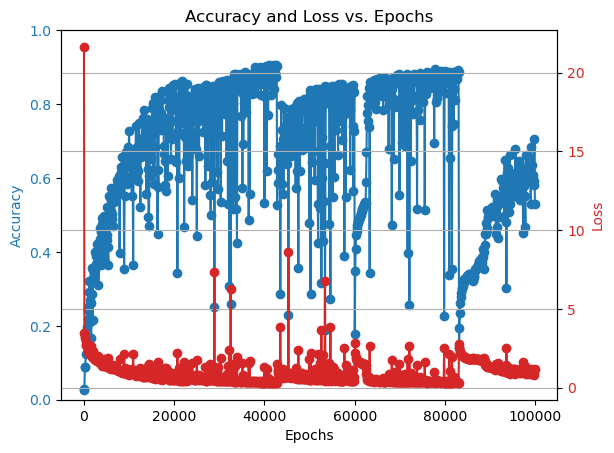

In [18]:
# Create a figure with two y-axes
fig, ax1 = plt.subplots()

# Plot accuracy on the first y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot([item[0] for item in history], [item[1] for item in history], marker='o', linestyle='-', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1)

# Create a second y-axis for the loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot([item[0] for item in history], [item[2] for item in history], marker='o', linestyle='-', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add labels and title
plt.title('Accuracy and Loss vs. Epochs')

# Display the graph
plt.grid(True)
plt.show()

# Testing the Model

Checking the Size of the Test Set

In [22]:
print("Size of Testing Set:", X_test.shape[1])

Size of Testing Set: 500


Getting the accuracy of the trained Neural Network on our seperated Test Set

In [23]:
print(f"Test Accuracy: {nn.get_accuracy(X_test, y_test) * 100:.2f}%")

Test Accuracy: 50.60%


Displaying predictions on the Test Set

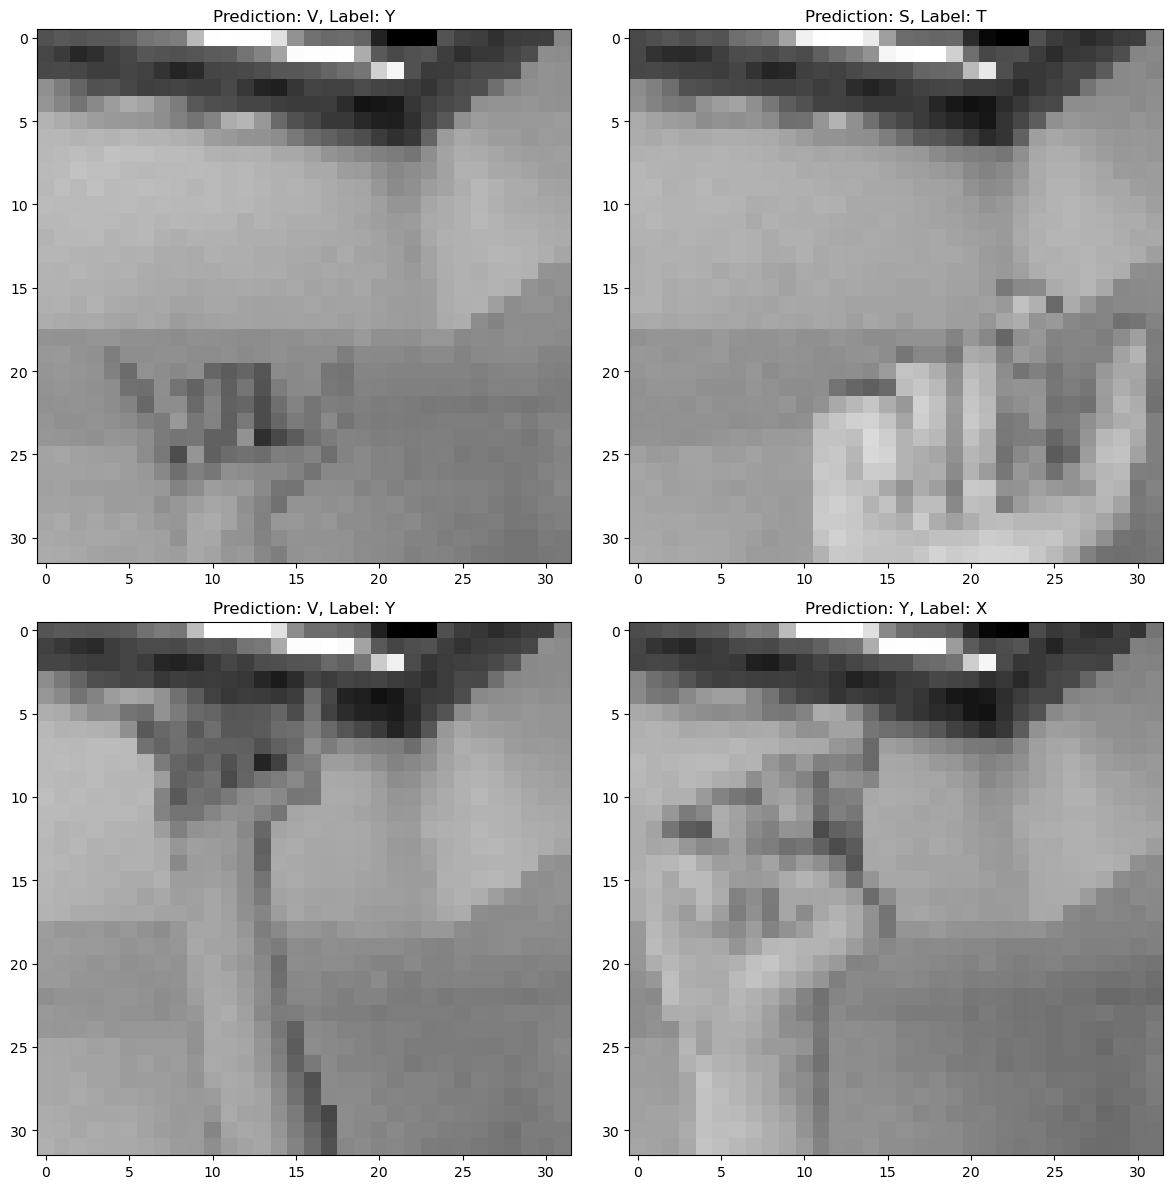

In [21]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Define the indices you want to test
indices = [0, 1, 2, 3]

for i, ax in enumerate(axes.flat):
    if i < len(indices):
        index = indices[i]
        current_image = X_test[:, index, None]
        label = y_test[index]
        prediction = nn.get_predictions(current_image)

        for key, number in class_number_dict.items():
            if prediction == number:
                prediction = key

            if label == number:
                label = key


        ax.imshow(current_image.reshape((PIXELSIZE, PIXELSIZE)) * 255, interpolation='nearest', cmap='gray')
        ax.set_title(f"Prediction: {prediction}, Label: {label}")
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout()
plt.show()